In [8]:
from mimic.utilities.utilities import set_all_seeds
from mimic.utilities.utilities import plot_CRM
from mimic.model_infer import *
from mimic.model_simulate import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import pymc as pm
import arviz as az
from pymc.ode import DifferentialEquation
from mimic.model_simulate.sim_CRM import sim_CRM
import pytensor.tensor as at


## Simulate some time course data from the CRM

The McArthur Consumer Resource Model takes the form


$$ dN_i/dt = 1/\tau_i N_i (\sum_a(c_{ia} w_a R_a - m_i)) $$
$$ dR_a/dt = 1/(r_a K_a) (K_a - R_a) R_a - \sum_i(N_i c_{ia} R_a) $$

where:
-   $N_i$ is the concentration of a species
-  $R_a$ is the concentration of a resource
-  $c_{ia}$ is the preference of species $i$ for resource $a$
- $w_a$ is the quality of resource $a$
-  $m_i$ is the mortality rate of species $i$
- $K_a$ is the carrying capacity of resource $a$
- $\tau_i$ is the timescale of species $i$
- $r_a$ is the timescale of resource $a$

### Generate parameters for model with two species

In [12]:
set_all_seeds(123)

num_species = 2
num_resources = 2
times = np.arange(0, 10, 0.1)


tau = np.array([0.6, 0.9])  # species timescales
w = np.array([0.5, 0.6])    # resource quality
c = np.array([[0.25, 0.08], [0.06, 0.22]])  # relative resource preferences
m = np.array([0.25, 0.28])  # mortality rates
r = np.array([0.4, 0.35])  # resource timescales
K = np.array([5.0, 6.0])  # resource carrying capacities

# tau = np.random.uniform(0.1, 0.9, num_species)      # species timescales
# w = np.random.uniform(0.1, 0.9, num_resources)      # resource quality
# c = np.random.uniform(0.1, 0.9, (num_species, num_resources))   # relative resource preferences
# m = np.random.uniform(0.3, 0.7, num_species)        # mortality rates
# r = np.random.uniform(0.1, 0.9, num_resources)      # resource timescales
# K = np.random.uniform(1.0, 10.0, num_resources)     # resource carrying capacities


# write the parameters to a dictionary and pickle
params = {'num_species': num_species, 'num_resources': num_resources, 'tau': tau, 'w': w, 'c': c, 'm': m, 'r': r, 'K': K}
pd.to_pickle(params, 'params-s2-r2.pkl')


In [13]:
print(params)

{'num_species': 2, 'num_resources': 2, 'tau': array([0.6, 0.9]), 'w': array([0.5, 0.6]), 'c': array([[0.25, 0.08],
       [0.06, 0.22]]), 'm': array([0.25, 0.28]), 'r': array([0.4 , 0.35]), 'K': array([5., 6.])}


### Simulate single time course

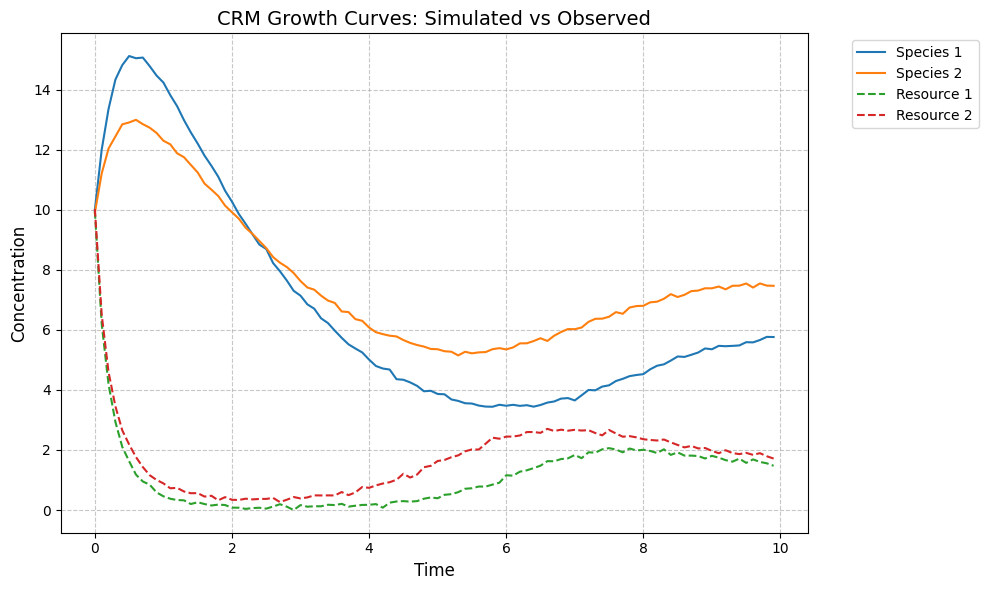

In [16]:
# initial conditions
init_species = 10 * np.ones(num_species+num_resources)

# instantiate simulator

simulator = sim_CRM()

simulator.set_parameters(num_species = params['num_species'],
                         num_resources = params['num_resources'],
                         tau = params['tau'],
                         w = params['w'],
                         c = params['c'],
                         m = params['m'],
                         r = params['r'],
                         K = params['K'])

simulator.print_parameters()

observed_species, observed_resources = simulator.simulate(times, init_species)
observed_data = np.hstack((observed_species, observed_resources))

# add Guassian noise to the data
observed_species = observed_species + np.random.normal(loc=0, scale=0.05, size=observed_species.shape)
observed_resources = observed_resources + np.random.normal(loc=0, scale=0.05, size=observed_resources.shape)

# Replace negative values with 0
observed_species = np.maximum(observed_species, 0.0001)
observed_resources = np.maximum(observed_resources, 0.0001)
 
# plot simulated species and resouce dynamics
plot_CRM(observed_species, observed_resources, times)


# Write the data to a csv file
df_species = pd.DataFrame(observed_species, columns=[f'species_{i + 1}' for i in range(observed_species.shape[1])])
df_resources = pd.DataFrame(observed_resources, columns=[f'resource_{i + 1}' for i in range(observed_resources.shape[1])])

# Add the time column to ensure combination matches up
df_species['time'] = times
df_resources['time'] = times

# create df with just species data to test resource inference
cols = ['time'] + [col for col in df_species.columns if col != 'time']
df_species = df_species[cols]

# Save species-only data
df_species.to_csv('data-s2-infer-r2.csv', index=False)

# Combine the species and resources into one DataFrame
df_combined = pd.concat([df_species.drop(columns=['time']), df_resources], axis=1)

# Ensure time is the first column
cols = df_combined.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_combined = df_combined[cols]

# Write the combined data to a CSV file
df_combined.to_csv('data-s2-r2.csv', index=False)

